# Predicción de precios de diamantes

Versión SkLearn

Se limpian los datos, se hace ingeniería de características y se prueban varios modelos de la librería.

In [28]:
# Se importan librerías

import time                                                   
import pandas as pd                                           
import matplotlib.pyplot as plt                               
%matplotlib inline
import seaborn as sns                                         
import numpy as np    

from sklearn.model_selection import train_test_split          
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV 

import warnings                                               
from sklearn.exceptions import DataConversionWarning          
warnings.filterwarnings(action='ignore', category=DataConversionWarning) 
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) 
warnings.filterwarnings("ignore")

In [2]:
diamond=pd.read_csv('diamonds_train.csv')
diamond.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


# Features

    · id: only for test & sample submission files, id for prediction sample identification
    
    · price: price in USD
    
    · carat: weight of the diamond
    
    · cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
    
    · color: diamond colour, from J (worst) to D (best)
    
    · clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
    
    · x: length in mm
    
    · y: width in mm
    
    · z: depth in mm
    
    · depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
    
    · table: width of top of diamond relative to widest point (43--95)


In [3]:
null = diamond.isnull().sum()
print (len(diamond))
null[null>0]

40455


Series([], dtype: int64)

In [11]:
diamond.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
carat      40455 non-null float64
cut        40455 non-null object
color      40455 non-null object
clarity    40455 non-null object
depth      40455 non-null float64
table      40455 non-null float64
price      40455 non-null int64
x          40455 non-null float64
y          40455 non-null float64
z          40455 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 9.5 MB


In [5]:
diamond.describe()

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797706,61.752841,57.446133,3928.444469,5.729392,5.732819,3.537154
std,0.475544,1.431725,2.233535,3992.416147,1.124453,1.146650,0.697062
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2397.000000,5.690000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5331.000000,6.540000,6.540000,4.035000
max,4.500000,79.000000,95.000000,18823.000000,10.230000,58.900000,8.060000


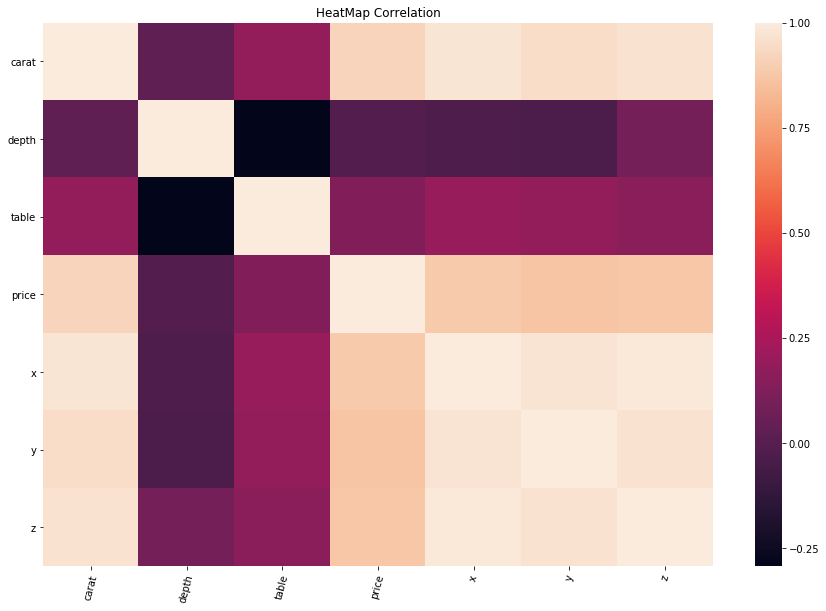

In [7]:
# buscando colinealidad

plt.figure(figsize=(15,10))          
sns.heatmap(diamond.corr())
plt.yticks(rotation=0)
plt.xticks(rotation=75)
plt.title('HeatMap Correlation')
plt.show();

In [8]:
# Se separan los datos de las etiquetas

X=diamond.drop(columns=['price'])
y=diamond.price

display (X.head())
display (y.head())

,carat,cut,color,clarity,depth,table,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95


0    4268
1     505
2    2686
3     738
4    4882
Name: price, dtype: int64

In [9]:
# tipos de color

X.color.unique()

array(['J', 'H', 'G', 'D', 'F', 'E', 'I'], dtype=object)

In [10]:
# tipos de claridad

X.clarity.unique()

array(['VS2', 'VS1', 'SI1', 'SI2', 'IF', 'VVS1', 'VVS2', 'I1'],
      dtype=object)

In [12]:
# one hot encode

X_dummie=pd.get_dummies(X, drop_first='True')
X_dummie.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.21,62.4,58.0,6.83,6.79,4.25,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0.32,63.0,57.0,4.35,4.38,2.75,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0.71,65.5,55.0,5.62,5.53,3.65,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.41,63.8,56.0,4.68,4.72,3.00,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.02,60.5,59.0,6.55,6.51,3.95,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [18]:
# normaliza one hot

scaler=StandardScaler()

X_dummie[['carat', 'depth', 'table', 'x', 'y', 'z']]=scaler.fit_transform(X_dummie[['carat', 'depth', 'table', 'x', 'y', 'z']])
X_dummie.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.867006,0.452019,0.247981,0.978807,0.921985,1.022657,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,-1.004557,0.871099,-0.199745,-1.226738,-1.179816,-1.129259,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,-0.184434,2.617265,-1.095198,-0.097286,-0.176882,0.161891,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-0.815298,1.429872,-0.647472,-0.933258,-0.883296,-0.770607,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.467458,-0.875068,0.695707,0.729794,0.677793,0.592274,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [17]:
# label encode

X_label=X.apply(LabelEncoder().fit_transform)
X_label.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,101,3,6,5,86,59,305,304,204
1,12,4,4,5,92,49,57,63,54
2,51,0,3,4,117,29,184,178,144
3,21,1,0,2,100,39,90,97,79
4,82,2,3,2,67,69,277,276,174


In [19]:
# normaliza label

X_label[['carat', 'depth', 'table', 'x', 'y', 'z']]=scaler.fit_transform(X_label[['carat', 'depth', 'table', 'x', 'y', 'z']])
X_label.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.871084,3,6,5,0.455614,0.276093,0.980925,0.950357,1.027489
1,-1.007648,4,4,5,0.878366,-0.195513,-1.229714,-1.213747,-1.136783
2,-0.184384,0,3,4,2.639833,-1.138725,-0.097653,-0.181083,0.161781
3,-0.817664,1,0,2,1.442035,-0.667119,-0.935556,-0.908437,-0.776071
4,0.470006,2,3,2,-0.883101,0.747698,0.731336,0.698926,0.594635


In [20]:
# train-test split

X_d_train, X_d_test, y_d_train, y_d_test=train_test_split(X_dummie, y, test_size=0.2)

X_l_train, X_l_test, y_l_train, y_l_test=train_test_split(X_label, y, test_size=0.2)

In [21]:
# modelos de regresion

# support vector regressor
# kernel = rbf, linear, poly, sigmoid....C=0.001,0.01,0.1,1
svr = SVR(kernel='rbf', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1)

# linear regression
# fit_intercept = True, False
linreg = LinearRegression(fit_intercept=True)

# random forest regressor
# n_estimators = 10, 100, 300 .....criterion=mse, mae
forest_reg = RandomForestRegressor(n_estimators=10, criterion='mse')

# stochastic gradient descent regressor
# loss = squared_loss, huber, epsilon_insensitive, squared_epsilon_insensitive...alpha = 0.0001, 0.01, 0.1
sgd = SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.0001, max_iter=500, epsilon=0.1)

# xgboosting regressor
# {'n_estimators': [100, 120, 160], 'max_depth':[3,5,7,9]}
xgbr = XGBRegressor(n_estimators=100, max_depth=3)

In [29]:
# gridsearching 

def grid_regressors(x_tr, y_tr, x_te, y_te, model, param, cv=5):
    start = time.time()
    grid = GridSearchCV(model, param, cv=cv, iid=True, return_train_score=True, n_jobs=-1)
    grid.fit(x_tr, y_tr)
    
    print ('Best score : {:.2f}'.format(grid.score(x_te, y_te)))
    print ('Best parameters: {}'.format(grid.best_params_))
    print ('Best score cross-val: {:.2f}'.format(grid.best_score_))
    
    params = list(grid.best_params_.keys())
    best_params = list(grid.best_params_.values())
    
    y_p = grid.best_estimator_.fit(x_tr, y_tr)  
    y_pred = y_p.predict(x_te) 
    print ('R2 score : {}'.format(r2_score(y_te, y_pred)))
    print ('RMSE: {}'.format(mean_squared_error(t_te, y_pred)))



# Con Dummies

In [ ]:
# svr model
params={'kernel': ['rbf'], 'C':[0.001]}
grid_regressors(X_d_train,y_d_train, X_d_test, y_d_test, svr, params)

In [ ]:
# linreg model
params={'fit_intercept': [True, False]}
grid_regressors(X_d_train,y_d_train, X_d_test, y_d_test, linreg, params)

In [ ]:
# forest model
params={'n_estimators': [10, 100, 300], 'criterion':['mse', 'mae']}
grid_regressors(X_d_train,y_d_train, X_d_test, y_d_test, forest_reg, params)

In [ ]:
# sgd model
params={'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'alpha':[0.0001, 0.01, 0.1]}
grid_regressors(X_d_train,y_d_train, X_d_test, y_d_test, sgd, params)

In [ ]:
# xgbr model
params={'n_estimators': [100, 120, 160], 'max_depth':[3,5,7,9]}
grid_regressors(X_d_train,y_d_train, X_d_test, y_d_test, xgbr, params)